# Project 2: Supervised Learning

### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

Identifying students who might need early intervention is a *classification* problem as you are sorting students into classes (*needs intervention*, *doesn't need intervention*) rather than trying to predict a quantitative value.

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [197]:
# Import libraries
import matplotlib
matplotlib.use('webagg')

import numpy as np
import numpy
import pandas as pd

# additional imports
import matplotlib.pyplot as plot
import seaborn
from sklearn.cross_validation import train_test_split

In [2]:
%matplotlib inline
RANDOM_STATE = 100
REPETITIONS = 100
# the plots take a long time
# only set to True if you need them
#RUN_PLOTS = True
RUN_PLOTS = False

In [3]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [4]:
n_students = student_data.shape[0]
assert n_students == student_data.passed.count()
n_features = student_data.shape[1] - 1
assert n_features == len(student_data.columns[student_data.columns != 'passed'])
n_passed = sum(student_data.passed.map({'no': 0, 'yes': 1}))
assert n_passed == len(student_data[student_data.passed == 'yes'].passed)
n_failed = n_students - n_passed
grad_rate = n_passed/float(n_students)
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(100 * grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


In [5]:
passing_rates = student_data.passed.value_counts()/student_data.passed.count()
print(passing_rates)

yes    0.670886
no     0.329114
Name: passed, dtype: float64


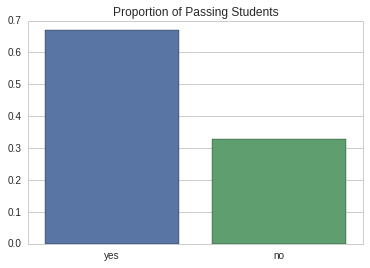

In [6]:
seaborn.set_style('whitegrid')
axe = seaborn.barplot(x=passing_rates.index, y=passing_rates.values)
title = axe.set_title("Proportion of Passing Students")

## 3. Preparing the Data

In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns

It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [7]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

In [8]:
print(len(X_all.columns))

30


### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [9]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
y_all = y_all.replace(['yes', 'no'], [1, 0])
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))


Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


In [10]:
len(X_all.columns)

48

### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [11]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all,
                                                    test_size=num_test,
                                                    train_size=num_train,
                                                    random_state=RANDOM_STATE)
assert len(y_train) == 300
assert len(y_test) == 95
print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models

Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

### Train a model

In [12]:
import time

def train_classifier(clf, X_train, y_train, verbose=True):
    if verbose:
        print "Training {}...".format(clf.__class__.__name__)
    times = []
    for repetition in range(REPETITIONS):
        start = time.time()
        clf.fit(X_train, y_train)
        times.append(time.time() - start)
    if verbose:
        print "Done!\nTraining time (secs): {:.3f}".format(min(times))

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

classifiers = [LogisticRegression(),
               RandomForestClassifier(),
               KNeighborsClassifier()]
for clf in classifiers:
    # Fit model to training data
    train_classifier(clf, X_train, y_train)  # note: using entire training set here


Training LogisticRegression...
Done!
Training time (secs): 0.004
Training RandomForestClassifier...
Done!
Training time (secs): 0.023
Training KNeighborsClassifier...
Done!
Training time (secs): 0.001


In [13]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target, verbose=True):
    if verbose:
        print "Predicting labels using {}...".format(clf.__class__.__name__)
    times = []
    scores = []
    for repetition in range(REPETITIONS):
        start = time.time()
        y_pred = clf.predict(features)
        times.append(time.time() - start)
        scores.append(f1_score(target.values, y_pred, pos_label=1))
    if verbose:
        print "Done!\nPrediction time (secs): {:.3f}".format(min(times))
    return np.median(scores)
    

In [14]:
# Predict on test data
for classifier in classifiers:
    print "F1 score for test set: {}".format(predict_labels(classifier,
                                                            X_test, y_test))

Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.812030075188
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.772727272727
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.003
F1 score for test set: 0.794520547945


In [15]:
class ClassifierData(object):
    """A Container for classifire performance data"""
    def __init__(self, classifier, f1_test_score, f1_train_score):
        """
        :param:
         - `classifier`: classifier object (e.g. LogisticRegression())
         - `f1_test_score`: score for the classifier on the test set
         - `f1_train_score`: score for the classifier on the training set
        """
        self.classifier = classifier
        self.f1_test_score = f1_test_score
        self.f1_train_score = f1_train_score
        return

In [16]:
from collections import defaultdict

# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test, verbose=True):
    if verbose:
        print "------------------------------------------"
        print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train, verbose)
    f1_train_score = predict_labels(clf, X_train, y_train, verbose)
    f1_test_score = predict_labels(clf, X_test, y_test, verbose)
    if verbose:
        print "F1 score for training set: {}".format(f1_train_score)
        print "F1 score for test set: {}".format(f1_test_score)
    return ClassifierData(clf, f1_test_score, f1_train_score)

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant
def train_by_size(sizes = [100, 200, 300], verbose=True):
    classifier_containers = {}
    for classifier in classifiers:
        name = classifier.__class__.__name__
        if verbose:
            print(name)
            print("=" * len(name))
        classifier_containers[name] = defaultdict(lambda: {})
        for size in sizes:
            x_train_sub, y_train_sub = X_train[:size], y_train[:size]
            assert len(x_train_sub) == size
            assert len(y_train_sub) == size
            classifier_data = train_predict(classifier, x_train_sub, y_train_sub, X_test, y_test, verbose)
            classifier_containers[name][size] = classifier_data
        if verbose:
            print('')
    return classifier_containers
_ = train_by_size()


LogisticRegression
------------------------------------------
Training set size: 100
Training LogisticRegression...
Done!
Training time (secs): 0.001
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.870229007634
F1 score for test set: 0.672
------------------------------------------
Training set size: 200
Training LogisticRegression...
Done!
Training time (secs): 0.003
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.833333333333
F1 score for test set: 0.791044776119
------------------------------------------
Training set size: 300
Training LogisticRegression...
Done!
Training time (secs): 0.004
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
Predicting labels using Log

In [17]:
if RUN_PLOTS:
    sizes = range(10, 310, 10)
    classifier_containers = train_by_size(sizes=sizes,
                                      verbose=False)

In [18]:
color_map = {'LogisticRegression': 'b',
             'KNeighborsClassifier': 'r',
             'RandomForestClassifier': 'm'}

In [19]:
def plot_scores(containers, which_f1='test', color_map=color_map):
    """
    Plot the f1 scores for the models
    
    :param:
    
     - `containers`: dict of <name><size> : classifier data
     - `which_f1`: 'test' or 'train'
     - `color_map`: dict of <model name> : <color string>
    """
    sizes = sorted(containers['LogisticRegression'].keys())
    figure = plot.figure()
    axe = figure.gca()
    for model in containers:
        scores = [getattr(containers[model][size], 'f1_{0}_score'.format(which_f1)) for size in sizes]
        axe.plot(sizes, scores, label=model, color=color_map[model])
    axe.legend(loc='lower right')
    axe.set_title("{0} Set F1 Scores by Training-Set Size".format(which_f1.capitalize()))
    axe.set_xlabel('Training Set Size')
    axe.set_ylabel('F1 Score')
    axe.set_ylim([0, 1.0])


In [20]:
if RUN_PLOTS:
    for f1 in 'train test'.split():
        plot_scores(classifier_containers, f1)

In [21]:
def plot_test_train(containers, model_name, color_map=color_map):
    """
    Plot testing and training plots for each model

    :param:
    
     - `containers`: dict of <model name><size>: classifier data
     - `model_name`: class name of the model
     - `color_map`: dict of <model name> : color string
    """    
    sizes = sorted(containers['LogisticRegression'].keys())
    figure = plot.figure()
    axe = figure.gca()
    test_scores = [containers[model][size].f1_test_score for size in sizes]
    train_scores = [containers[model][size].f1_train_score for size in sizes]
    axe.plot(sizes, test_scores, label="Test", color=color_map[model])
    axe.plot(sizes, train_scores, '--', label="Train", color=color_map[model])
    axe.legend(loc='lower right')
    axe.set_title("{0} F1 Scores by Training-Set Size".format(model))
    axe.set_xlabel('Training Set Size')
    axe.set_ylabel('F1 Score')
    axe.set_ylim([0, 1.0])
    return

In [22]:
if RUN_PLOTS:
    for model in color_map.keys():
        plot_test_train(classifier_containers, model)

## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

Based on the previous experiments I chose *Logistic Regression* as the classifier to use. Given the data available, all three models have comparable F1 scores (on the test data) but the Logistic Regression classifier is the fastest for both training and prediction when compared to *K-Nearest Neighbor* and *Random Forests*. In addition, the Logistic Regression classifier offers readily interpretable coefficients and L1 regression to sparsify the data, allowing us to see the most important of the variables when deciding who will pass their final exam.

Logistic Regression works by estimating the probability that a student's attributes - such as their age, how often they go out, etc. -  predicts that they will pass. It does this using the *logistic function* which creates an S-shaped curve which goes to 0 at negative infinity and 1 at positive infinity:

In [23]:
%%latex
P(passed=yes|x) = \frac{1}{1+e^{-weights^T \times attributes}}\\

<IPython.core.display.Latex object>

Here *attributes* is a vector of student attributes and *weights* is the vector of weights that the Logistic Regression algorithm finds. To see what this function looks like I'll plot its output when there is a weight of one and a single attribute whose values are centered around 0, since this is a fictional attribute that I'm creating for plotting I'll call it *x*.

In [46]:
import plotly
import plotly.tools as tls
plotly.offline.init_notebook_mode()

In [47]:
x = np.linspace(-6, 7, 100)
y = 1/(1 + np.exp(-x))
figure = plot.figure()
axe = figure.gca()
axe.plot(x, y)
title = axe.set_title("Sigmoid Function")
axe.set_ylabel(r"P(passed=yes|x)")
label = axe.set_xlabel("x")
plotly_fig = tls.mpl_to_plotly(figure)
plotly.offline.iplot(plotly_fig)

To clarify the previous equation, if we only had two attributes, *age* and *school* to predict if a student passed, then it could be written as:

In [25]:
%%latex
\textit{probability student passed given age and school} = \frac{1}{1+e^{-(intercept + w_1 \times age + w_2 * school)}}\\

<IPython.core.display.Latex object>

The goal of the Logistic Regression algorithm is to find the weights that most accurately predict whether a given student passes or not. In other words, it seeks to find the values for the weights so that the logistic function most accurately produces a probability greater than :math:`\frac{1}{2}` if the student passed and a probablity less than :math:`\frac{1}{2}` if the student did not pass.

### Set up the parameters

In [26]:
from sklearn.metrics import f1_score, make_scorer
scorer = make_scorer(f1_score)
passing_ratio = (sum(y_test) +
                 sum(y_train))/float(len(y_test) +
                                     len(y_train))
assert abs(passing_ratio - .67) < .01
model = LogisticRegression()

In [27]:
# python standard library
import warnings

# third party
from sklearn.grid_search import GridSearchCV

parameters = {'penalty': ['l1', 'l2'],
              'C': np.arange(.01, 1., .01),
              'class_weight': [None, 'balanced', {1: passing_ratio, 0: 1 - passing_ratio}]}

### Grid search

In [28]:
grid = GridSearchCV(model, param_grid=parameters, scoring=scorer, cv=10, n_jobs=-1)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    grid.fit(X_train, y_train)

### The best parameters

In [29]:
grid.best_params_

{'C': 0.089999999999999997, 'class_weight': None, 'penalty': 'l1'}

### The Coefficients

In [30]:
column_names = X_train.columns
coefficients = grid.best_estimator_.coef_[0]
odds = np.exp(coefficients)
sorted_coefficients = sorted((column for column in coefficients), reverse=True)

non_zero_coefficients = [coefficient for coefficient in sorted_coefficients
                         if coefficient != 0]
non_zero_indices = [np.where(coefficients==coefficient)[0][0] for coefficient in non_zero_coefficients]
non_zero_variables = [column_names[index] for index in non_zero_indices]
non_zero_odds = [odds[index] for index in non_zero_indices]
for column, coefficient, odds_ in zip(non_zero_variables, non_zero_coefficients, non_zero_odds):
    print('{0: <10}{1: >5.2f}\t{2: >8.2f}'.format(column, coefficient, odds_))


Medu       0.14	    1.16
age        0.03	    1.03
famrel     0.03	    1.03
Fedu       0.01	    1.01
absences  -0.02	    0.98
goout     -0.07	    0.93
failures  -0.46	    0.63


In [31]:
feature_map = {"school": "student's school",
               "sex": "student's sex",
               "age": "student's age",
               "address": "student's home address type",
               "famsize": "family size",
               "Pstatus": "parent's cohabitation status",
               "Medu": "mother's education",
               "Fedu": "father's education",
               "Mjob": "mother's job",
               "Fjob": "father's job",
               "reason": "reason to choose this school",
               "guardian": "student's guardian",
               "traveltime": "home to school travel time",
               "studytime": "weekly study time",
               "failures": "number of past class failures",
               "schoolsup": "extra educational support",
               "famsup": "family educational support",
               "paid": "extra paid classes within the course subject (Math or Portuguese)",
               "activities": "extra-curricular activities",
               "nursery": "attended nursery school",
               "higher": "wants to take higher education",
               "internet": "Internet access at home",
               "romantic": "within a romantic relationship",
               "famrel": "quality of family relationships",
               "freetime": "free time after school",
               "goout": "going out with friends",
               "Dalc": "workday alcohol consumption",
               "Walc": "weekend alcohol consumption",
               "health": "current health status",
               "absences": "number of school absences",
               "passed": "did the student pass the final exam"}

The plots were originally created separately for the write-up but I'm putting the code here too to show how they were made.

In [59]:
def plot_counts(x_name, hue='passed'):
    """
    plot counts for a given variable

    :param:
    
     - `x_name`: variable name in student data
     - `hue`: corellating variable
    """
    title = "{0} vs Passing".format(feature_map[x_name].title())
    figure = plot.figure()
    axe = figure.gca()
    axe.set_title(title)
    lines = seaborn.countplot(x=x_name, hue=hue, data=student_data)
    

In [64]:
def plot_probabilities(column_name):
    """
    Plots the probabilities for the given column's unique inputs

    :param:
     -`column_name`: Name of feature-column
    """
    descriptive_name = feature_map[column_name]
    figure = plot.figure(figsize=(10, 8))
    axe = figure.gca()
    title = "Probability for {0}".format(descriptive_name.title())
    axe.set_title(title)
    axe.set_xlabel(descriptive_name)

    index = numpy.where(X_test.columns==column_name)
    x_input = numpy.zeros((1, len(X_test.columns)))
    x = [value for value in sorted(X_test[column_name].unique())]
    y = []
    axe.set_xlim((min(x), max(x)))
    axe.set_ylim((0, 1))    

    for value in x:
        x_input[0][index] = value
        y.append(grid.best_estimator_.predict_proba(x_input)[0])
    lines = plot.plot(x, y)
    plotly_fig = tls.mpl_to_plotly(figure)
    plotly.offline.iplot(plotly_fig)

In [34]:
def plot_predictions(column_name):
    descriptive_name = feature_map[column_name]
    figure = plot.figure(figsize=(10, 8))
    axe = figure.gca()
    title = "Prediction for {0}".format(descriptive_name.title())
    axe.set_title(title)
    index = np.where(X_test.columns==column_name)
    x_input = np.zeros((1, len(X_test.columns)))
    y = []
    x = np.array([value for value in sorted(X_test[column_name].unique())])
    axe.set_xlim((min(x), max(x)))
    axe.set_ylim((-.5, 1.5))
    axe.set_xlabel(descriptive_name)
    axe.set_ylabel("prediction (1='passed' 0='failed')")
    for value in x:
        x_input[0][index] = value
        y.append(grid.predict(x_input))
    lines = plot.plot(x , y)


In [35]:
def plot_three(column_name):
    plot_counts(column_name)
    plot_predictions(column_name)
    plot_probabilities(column_name)

In [141]:
from bokeh import mpl
from bokeh.charts import Scatter
from bokeh.io import output_notebook
from bokeh.models import HoverTool
from bokeh.plotting import show
from bokeh.plotting import figure as b_figure

from sklearn.preprocessing import MinMaxScaler

fig = b_figure(tools=[HoverTool()], title='Variable Probabilities')
scaler = MinMaxScaler()

output_notebook()

Loading BokehJS ...

(95, 2)

In [173]:
import pandas
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    x_norm = X_test.apply(scaler.fit_transform)
y_output = pandas.DataFrame.from_dict({"passed": [y_probabilities]})

from bokeh.models.sources import ColumnDataSource

In [228]:
figure = plot.figure(figsize=(10,8))
axe = figure.gca()
from sklearn.preprocessing import MinMaxScaler
from bokeh.palettes import Spectral7
tools = "pan,wheel_zoom,box_zoom,reset,resize,hover"
#tooltips = [('Variable', '@{0}'.format(variable)) for variable in non_zero_variables]
#fig = b_figure(tools=tools, title='Variable Probabilities')
scaler = MinMaxScaler()
#x_normed = normalize(X_test)
for v_index, variable in enumerate(non_zero_variables):
    index = numpy.where(X_test.columns==variable)
    x_input = numpy.zeros((1, len(X_test.columns)))
    x = numpy.array([value for value in sorted(X_test[variable].unique())])
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        x = scaler.fit_transform(x)
    y = []
    x = [x[0], x[-1]]
    for value in x:
        x_input[0][index] = value
        y.append(grid.best_estimator_.predict_proba(x_input)[0][1])
    lines = plot.plot(x, y, label=variable)
    #source = ColumnDataSource({variable: x, 'passed': y, 'name': [variable for item in x]})
    
    #fig.circle(variable, 'passed', name=variable, source=source)
    #hover = fig.select(dict(type=HoverTool))
    #hover.tooltips = [('Variable', '@name'), ("(x, y)", '($x, $y)')]
    #hover.mode = 'mouse'
    #hover.line_policy='none'
    #fig.line(x, y, source=source, line_color=Spectral7[v_index], legend=variable)
    #df = pandas.DataFrame.from_dict({variable: x, 'passed':y})
    #s = Scatter(df, x=variable, y='passed')
title = axe.set_title("Variable Probabilities")
#legend = axe.legend(loc='lower left')

plotly_fig = tls.mpl_to_plotly(figure)
plotly.offline.iplot(plotly_fig)

#handle = show(mpl.to_bokeh())
#fig.legend.location = 'bottom_left'
#handle = show(fig)

In [162]:
fig = b_figure(tools=[HoverTool()], title='Variable Probabilities')
variable = 'Medu'

index = numpy.where(X_test.columns==variable)
x_input = numpy.zeros((1, len(X_test.columns)))
x = numpy.array([value for value in sorted(X_test[variable].unique())])
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    x = scaler.fit_transform(x)
y = []
for value in x:
    x_input[0][index] = value
    y.append(grid.best_estimator_.predict_proba(x_input)[0][1])
df = pandas.DataFrame.from_dict({variable: x, 'passed':y})    
Scatter(df, x=variable, y='passed')
show(fig)


In [91]:
figure = plot.figure(figsize=(10,8))
axe = figure.gca()
for variable in non_zero_variables:
    index = numpy.where(X_test.columns==variable)
    x_input = numpy.zeros((1, len(X_test.columns)))
    x = numpy.array([value for value in sorted(X_test[variable].unique())])
    #x = scaler.fit_transform(x)
    y = []
    for value in x:
        x_input[0][index] = value
        y.append(grid.best_estimator_.predict_proba(x_input)[0][1])
    lines = plot.plot(x, y, label=variable)
title = axe.set_title("Variable Probabilities")
#legend = axe.legend(loc='lr')
plotly_fig = tls.mpl_to_plotly(figure)
plotly.offline.iplot(plotly_fig)


## Medu

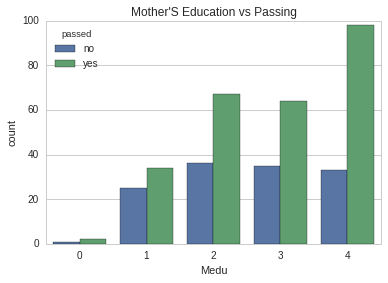

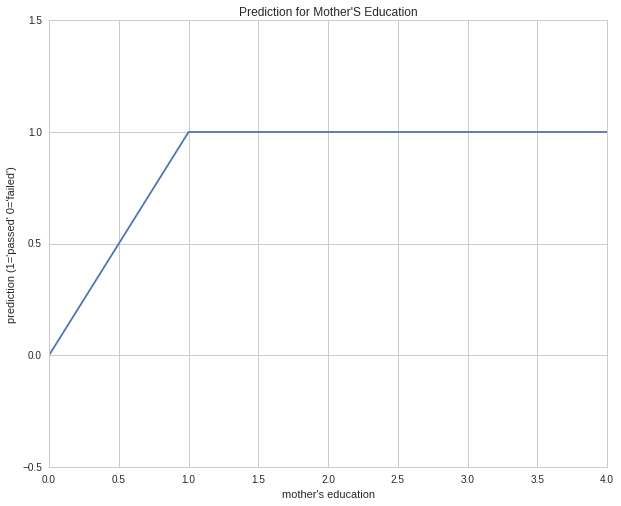

In [66]:
plot_three('Medu')

## famrel

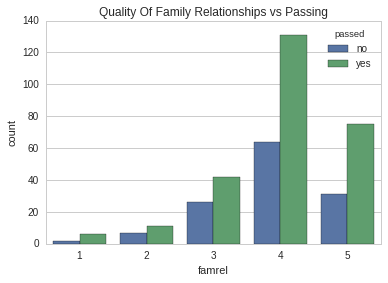

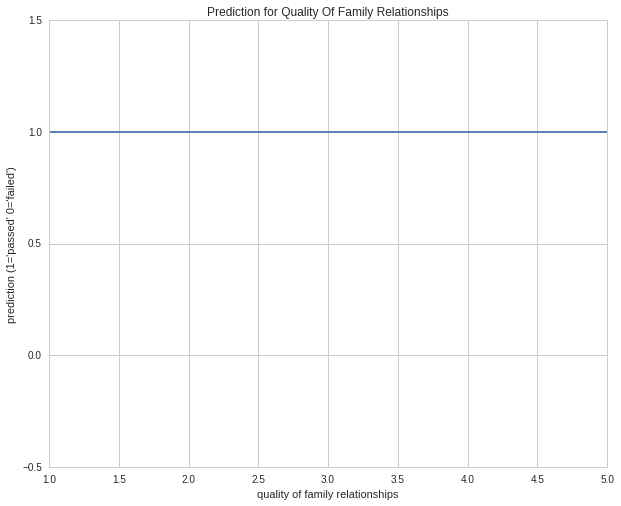

In [67]:
plot_three('famrel')

## Fedu

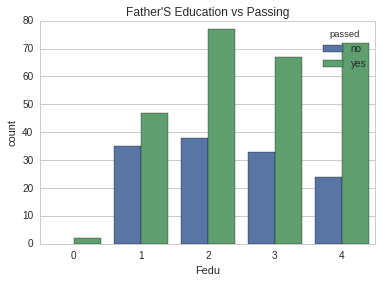

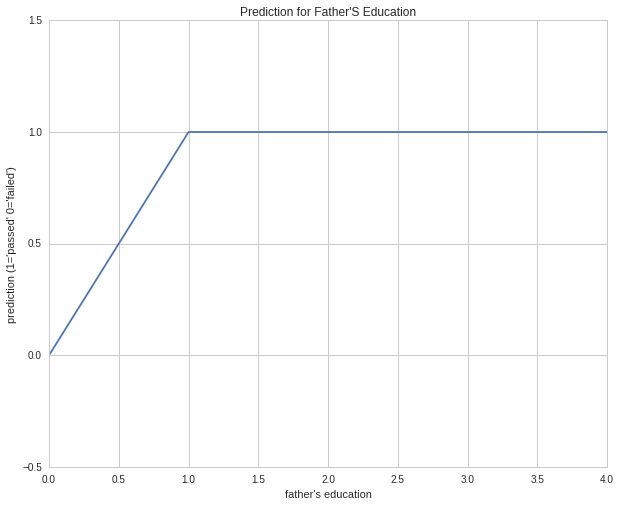

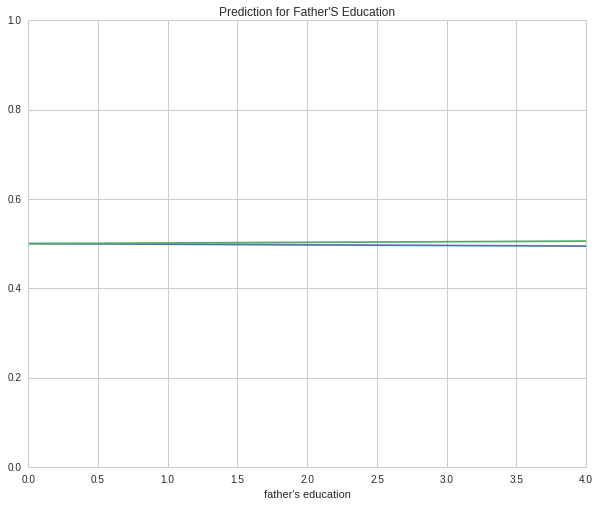

In [38]:
plot_three('Fedu')

## goout

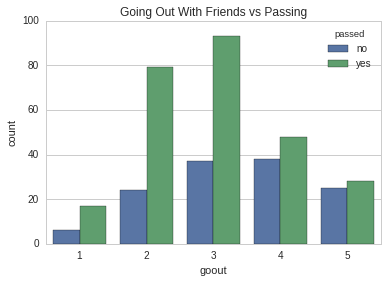

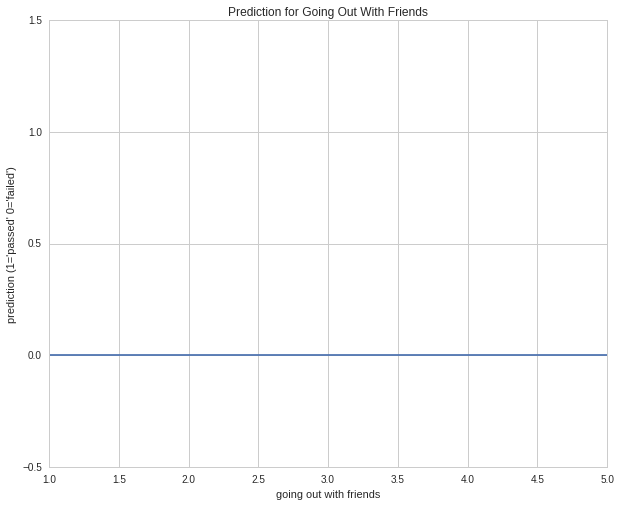

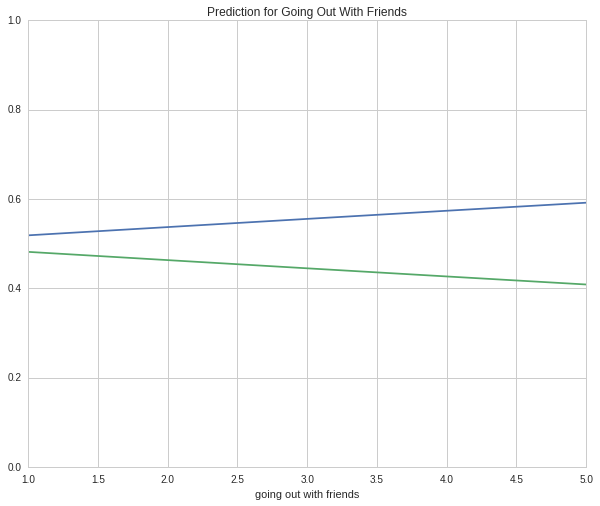

In [39]:
plot_three('goout')

## failures

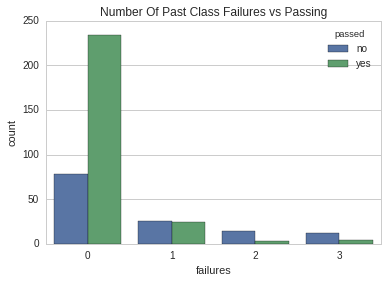

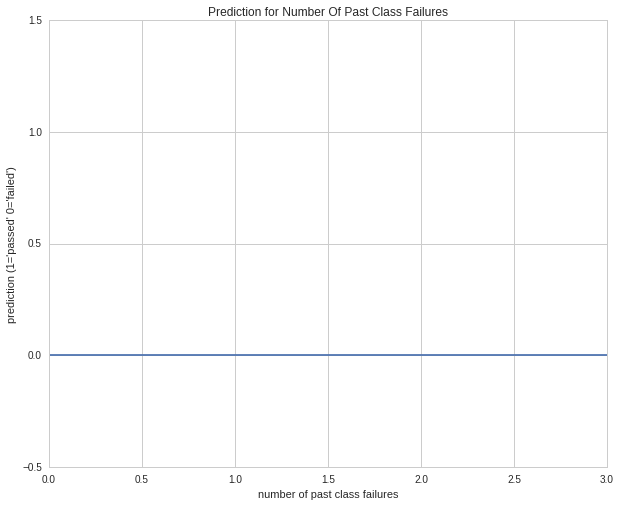

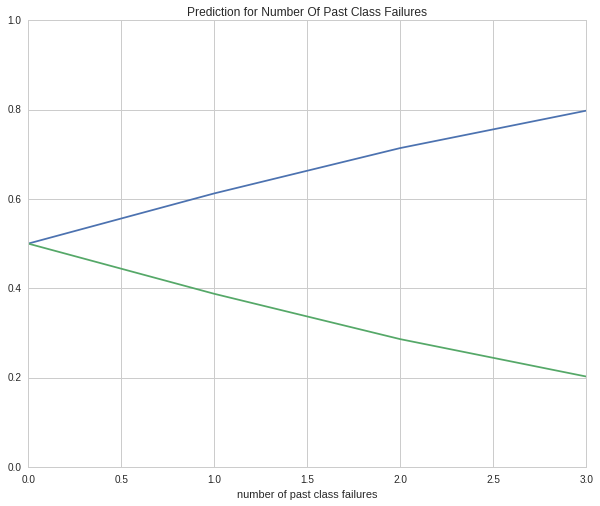

In [40]:
plot_three('failures')

## age

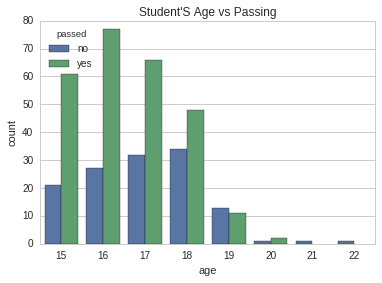

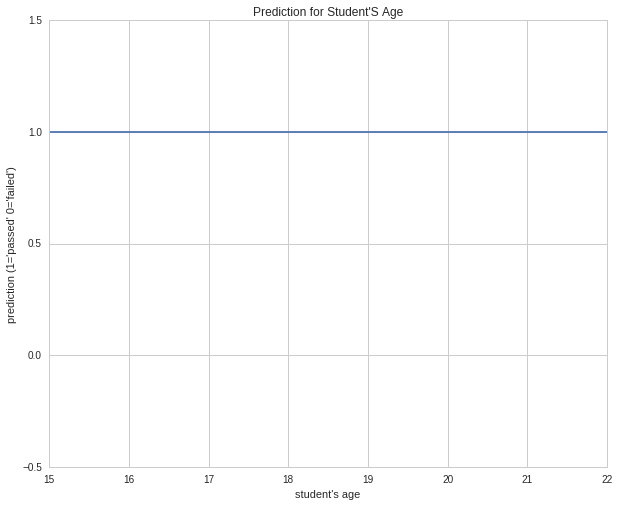

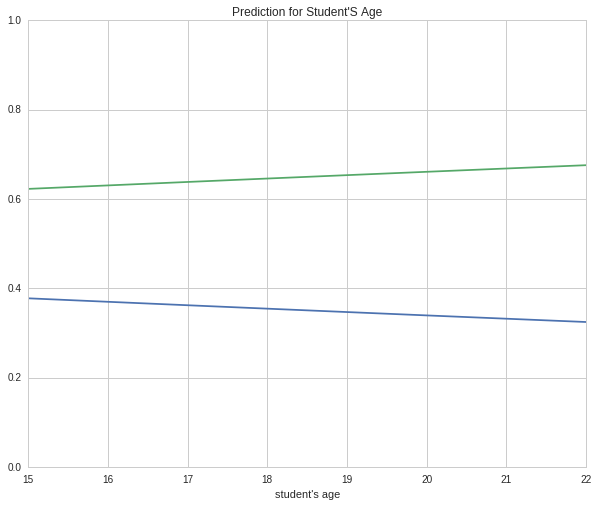

In [41]:
plot_three('age')

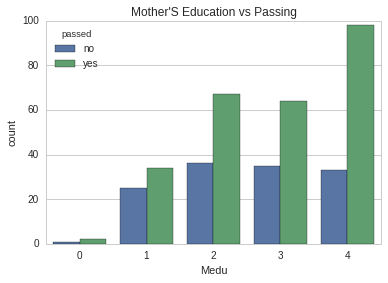

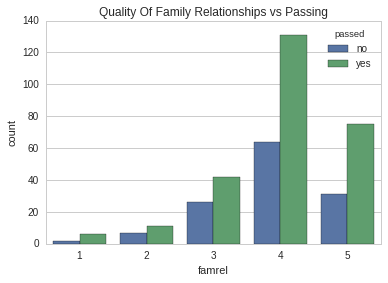

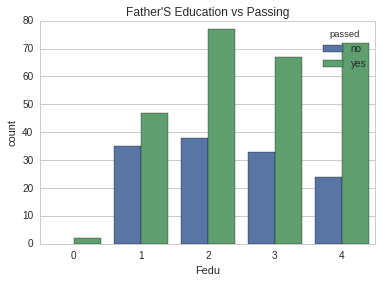

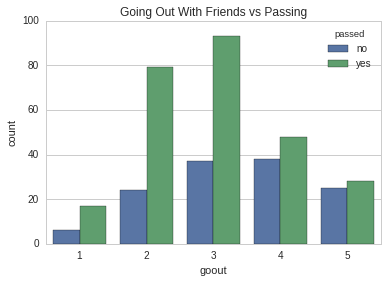

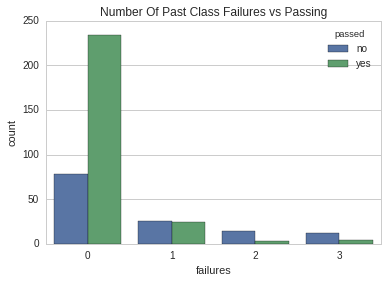

In [42]:
count_plot_variables = [name for name in non_zero_variables
                        if name not in ('age', 'absences')]
for variable in count_plot_variables:
    plot_counts(variable)

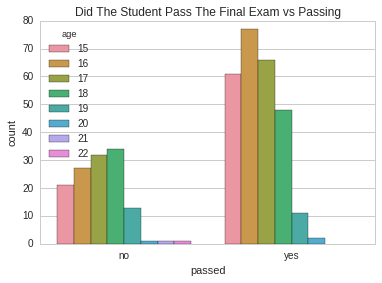

In [43]:
plot_counts('passed', 'age')

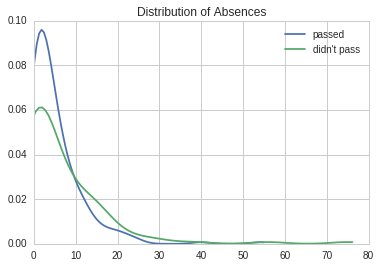

In [44]:
axe = seaborn.kdeplot(student_data[student_data.passed=='yes'].absences, label='passed')
axe.set_title('Distribution of Absences')
axe.set_xlim([0, 80])
axe = seaborn.kdeplot(student_data[student_data.passed=='no'].absences, ax=axe, label="didn't pass")

## Final F1 Score

In [45]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print("{0:.2f}".format(grid.score(X_test, y_test)))

0.86
